# Google Area41 challenge 2022

Google distributed as usual a challenge at their booth at Area41:

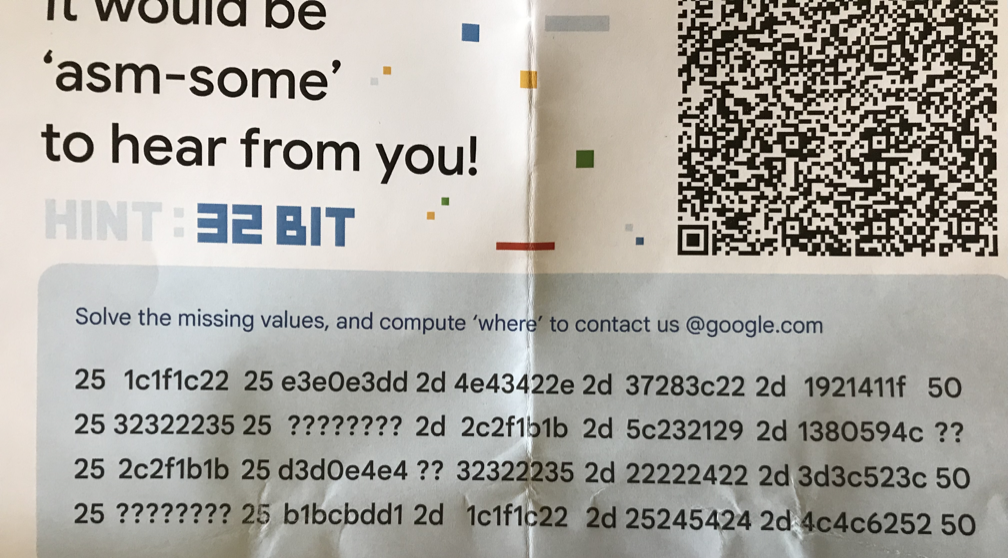

Let's solve it! :-)
Looking at their flyer we can already spot some hints: It would be **asm-some** to hear from you and **Hint:32-Bit**.
**asm-some** is a hint that probably some assembly code / machine code is involved in the challenge. **32-Bit** is a hint towards the specific architecture used for the machine code.
We can therefore assume that the shown hex values at the bottom of the challenge flyer represent machine code. There are also some bytes missing, which we have to find.

First let's define some byte arrays for the hex values shown:

In [ ]:
# set undefined dwords to 0xCAFEBABE and bytes to 0x90
code1=bytes.fromhex("25 1c1f1c22 25 e3e0e3dd 2d 4e43422e 2d 37283c22 2d 1921411f 50")
code2=bytes.fromhex("25 32322235 25 CAFEBABE 2d 2c2f1b1b 2d 5c232129 2d 1380594c 90")
code3=bytes.fromhex("25 2c2f1b1b 25 d3d0e4e4 90 32322235 2d 22222422 2d 3d3c523c 50")
code4=bytes.fromhex("25 CAFEBABE 25 b1bcbdd1 2d 1c1f1c22 2d 25245424 2d 4c4c6252 50")

Then let's assume the defined hex bytes are 32-bit machine code for the x86 CPU architecture.
We can test this assumption by trying to dissasseble the corresponding opcodes:

In [2]:
from capstone import *
md = Cs(CS_ARCH_X86, CS_MODE_32)

In [3]:
def disasm(code):
    for i in md.disasm(code, 0x1000):
        print("0x%x:\t%s\t%s" %(i.address, i.mnemonic, i.op_str))

In [4]:
disasm(code1)

0x1000:	and	eax, 0x221c1f1c
0x1005:	and	eax, 0xdde3e0e3
0x100a:	sub	eax, 0x2e42434e
0x100f:	sub	eax, 0x223c2837
0x1014:	sub	eax, 0x1f412119
0x1019:	push	eax


Our assumption seems to be correct as the resulting assembly code looks reasonable. Looking at the code, we can already infer some things:

* 0x25 seems to be the opcode for the **and** operation
* 0x2d seems to be the opcode for the **sub** operation
* 0x50 seems to be the opcode for the **push** operation

Using these insights, the can easily replace the missing bytes in the machine code:

In [5]:
code1=bytes.fromhex("25 1c1f1c22 25 e3e0e3dd 2d 4e43422e 2d 37283c22 2d 1921411f 50")
code2=bytes.fromhex("25 32322235 25 CAFEBABE 2d 2c2f1b1b 2d 5c232129 2d 1380594c 50")
code3=bytes.fromhex("25 2c2f1b1b 25 d3d0e4e4 2d 32322235 2d 22222422 2d 3d3c523c 50")
code4=bytes.fromhex("25 CAFEBABE 25 b1bcbdd1 2d 1c1f1c22 2d 25245424 2d 4c4c6252 50")

To solve this challenge, we must execute the given machine code and inspect the values written to the stack by the **push eax** instructions.
Emulation is perfectly suited to solve these kind of problems. Let's use the excellent Unicorn emulator (https://www.unicorn-engine.org/) to emulate the given machine code.
First let's import unicorn and define the start address for our emulation. This is also the address where we'll copy our machine code to.

In [6]:
from unicorn import *
from unicorn.x86_const import *

# memory address where emulation starts
ADDRESS = 0x0

Let's define a function which takes a byte array containing code to emulate and also a start value for the **eax** register:

In [7]:
from io import StringIO
buffer=StringIO()

def dump_stack(uc):
    """
        try to find bytes in the ascii range on the stack and write them to a buffer
    """
    stack_addr=uc.reg_read(UC_X86_REG_ESP)
    for i in range(4):
        try:
            buffer.write(uc.mem_read(stack_addr+i, 1).decode('ascii'))
        except:
            buffer.write('X')

def hook_code(uc, address, size, user_data):
    """
        function executed after every emulation instruction. Used to print the value of eax when pushed to the stack
    """
    tmp = uc.mem_read(address, size)

    for i in md.disasm(tmp, 0):
        
        if i.mnemonic == 'push':
            eax=uc.reg_read(UC_X86_REG_EAX)
            print(f"pushing eax to stack: {hex(eax)}") 

def emulate(code, eax=0x0):
    """
        emulate given code, set eax to given value
    """
    try:
        mu = Uc(UC_ARCH_X86, UC_MODE_32)                   # use 32-bit mode of x86 architecture
        mu.mem_map(ADDRESS, 2 * 1024 * 1024)               # allocate some memory in the emulator
        mu.mem_write(ADDRESS, code)                        # copy code to emulate to the emulator at the defined address (=0x0)
        mu.reg_write(UC_X86_REG_ESP, ADDRESS + 0x100000)   # setup a stack by setting esp to 0x100000
        mu.reg_write(UC_X86_REG_EAX,eax)                   # initialize eax to the given value, default is 0x0
        mu.hook_add(UC_HOOK_CODE, hook_code)               # add a hook for every execution instruction
        mu.emu_start(ADDRESS, ADDRESS + len(code))         # start emulation at given address
        dump_stack(mu)                                     # dump strings found on the stack
        
    except UcError as e:
        print("ERROR: %s" % e)

We can now start to emulate the machine code stored in the corresponding byte arrays code1 to code4.
Since the individul parts of the solution string are pushed onto the stack, we must inverse the order of the code blocks emulated to get the correct solution string:

In [8]:
emulate(code4, eax=0)
emulate(code3, eax=0)
emulate(code2, eax=0)
emulate(code1, eax=0)

print(f"\nThe flag is: {buffer.getvalue().replace('X', 'google.com')}")

pushing eax to stack: 0x672d7073
pushing eax to stack: 0x6c676f6f
pushing eax to stack: 0x6f6a2d65
pushing eax to stack: 0x90407362

The flag is: sp-google-jobs@google.com


Interestingly we found the correct solution despite having defined the missing dwords as `0xCAFEBABE`. The magic of logical **and** made the lifer easier for us ;-)

# Solution using IDA and flare-emu

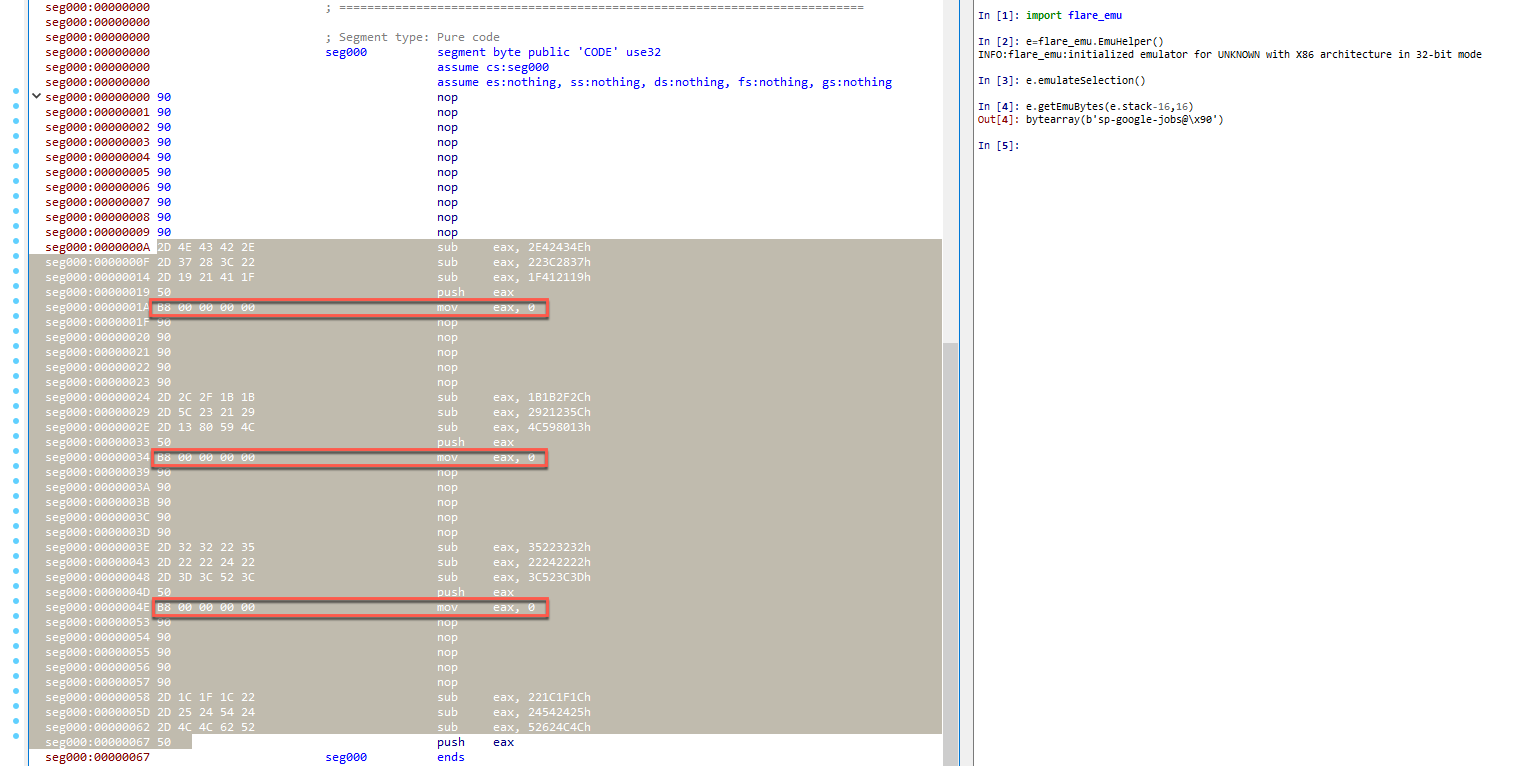